<a href="https://colab.research.google.com/github/Bob-Gohardani/nlp-ml/blob/main/logistic_regression_predicting_user_subscription.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from dateutil import parser # for parsing date, time values
import time 

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

import os
print(os.listdir("../input"))

['top-screens', 'subscription-train']


* **Importing and Exploring the dataset**

We are given a dataset that includes the data about a mobile App,this is a free app with subscription mode<br>
our main goal here is to predict which users are UNLIKELY to subscribe to the app, so we would focus most of<br>
our advertisement efforts on them

In [ ]:
dataset = pd.read_csv("../input/subscription-train/train.csv")

In [ ]:
dataset.head()

,user,first_open,dayofweek,hour,age,screen_list,numscreens,minigame,used_premium_feature,enrolled,enrolled_date,liked
0,235136,2012-12-27 02:14:51.273,3,02:00:00,23,"idscreen,joinscreen,Cycle,product_review,ScanP...",15,0,0,0,NaN,0
1,333588,2012-12-02 01:16:00.905,6,01:00:00,24,"joinscreen,product_review,product_review2,Scan...",13,0,0,0,NaN,0
2,254414,2013-03-19 19:19:09.157,1,19:00:00,23,"Splash,Cycle,Loan",3,0,1,0,NaN,1
3,234192,2013-07-05 16:08:46.354,4,16:00:00,28,"product_review,Home,product_review,Loan3,Finan...",40,0,0,1,2013-07-05 16:11:49.513,0
4,51549,2013-02-26 18:50:48.661,1,18:00:00,31,"idscreen,joinscreen,Cycle,Credit3Container,Sca...",32,0,0,1,2013-02-26 18:56:37.841,1


As can be seen above we have data from when users first open the app, what age they are , what features of the app<br> 
they used(screen_list), number of this used features,did they ever used premium trial, did they like the app and most<br> importnantly if they ever enrolled and if they did, when did it happen
* my first impression is that screen_list, used_premium_features, liked would be the most 3 important features of the data set.

In [ ]:
dataset.describe()   # we have 50K rows in our dataset.

,user,dayofweek,age,numscreens,minigame,used_premium_feature,enrolled,liked
count,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,186889.729900,3.029860,31.72436,21.095900,0.107820,0.172020,0.621480,0.165000
std,107768.520361,2.031997,10.80331,15.728812,0.310156,0.377402,0.485023,0.371184
min,13.000000,0.000000,16.00000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,93526.750000,1.000000,24.00000,10.000000,0.000000,0.000000,0.000000,0.000000
50%,187193.500000,3.000000,29.00000,18.000000,0.000000,0.000000,1.000000,0.000000
75%,279984.250000,5.000000,37.00000,28.000000,0.000000,0.000000,1.000000,0.000000
max,373662.000000,6.000000,101.00000,325.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
dataset.hour.head() # this is when the user first opened the app

# turn the hour column into int from string
dataset.hour = dataset.hour.str.slice(1,3).astype(int)

In [ ]:
dataset.hour.head(3)

0     2
1     1
2    19
Name: hour, dtype: int64

In [ ]:
# we create a second dataset for visualization and drop id and string data
ds = dataset.copy().drop(columns=['user','screen_list', 'enrolled_date', 'first_open', 'enrolled'])

In [ ]:
ds.head()

,dayofweek,hour,age,numscreens,minigame,used_premium_feature,liked
0,3,2,23,15,0,0,0
1,6,1,24,13,0,0,0
2,1,19,23,3,0,1,1
3,4,16,28,40,0,0,0
4,1,18,31,32,0,0,1


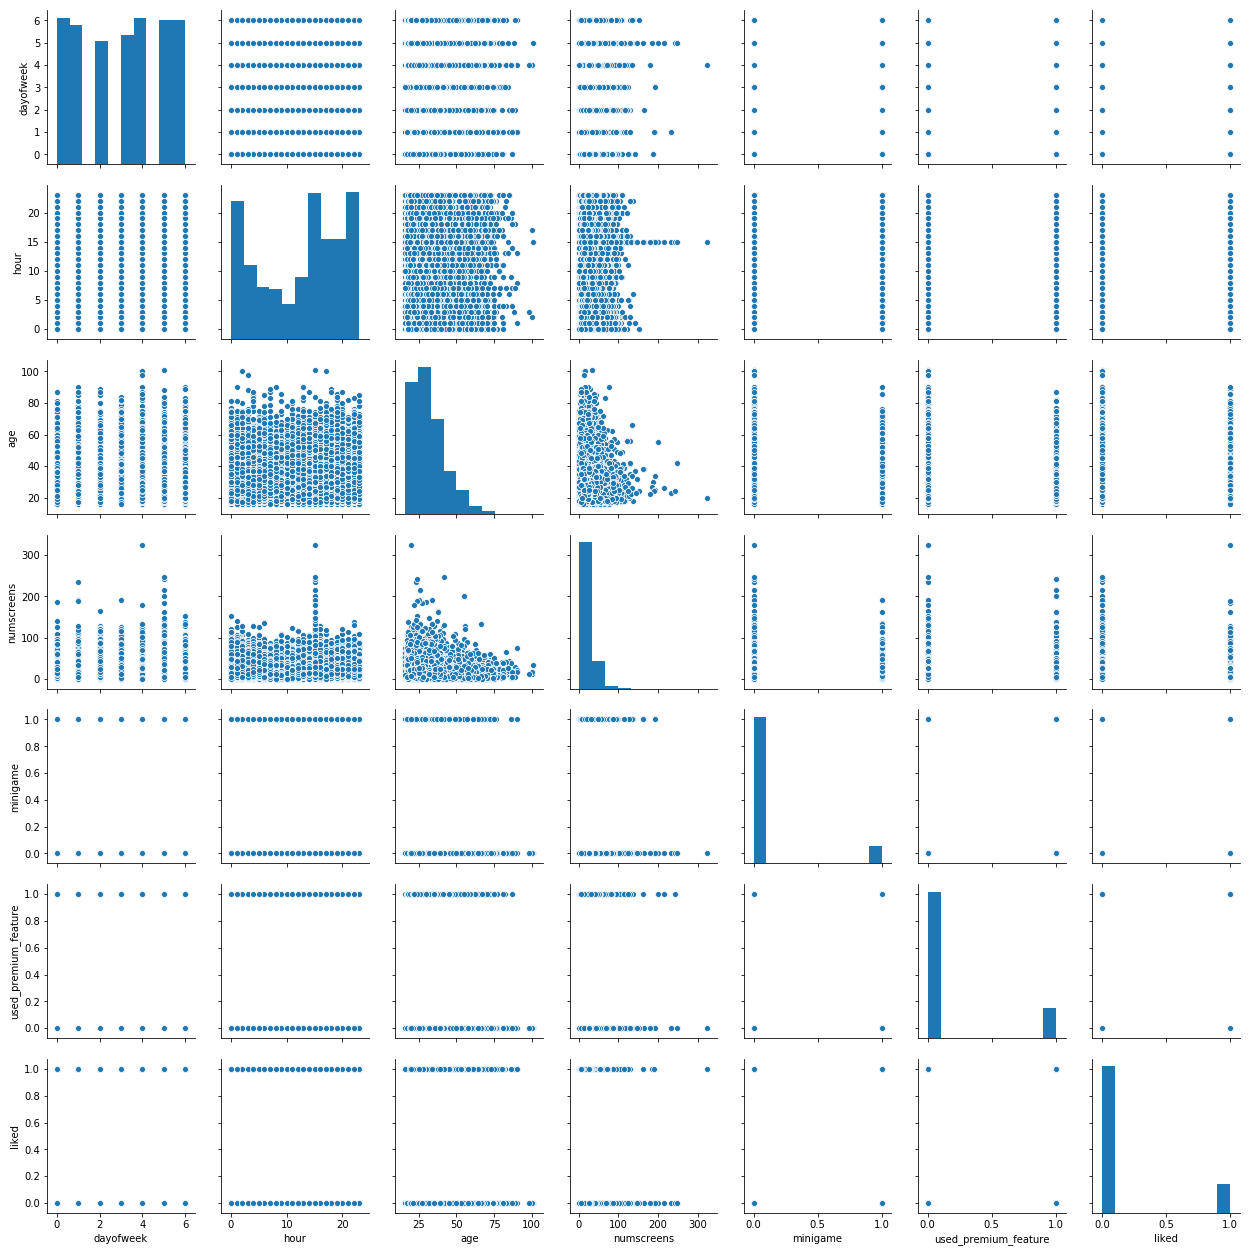

In [ ]:
sns.pairplot(ds)

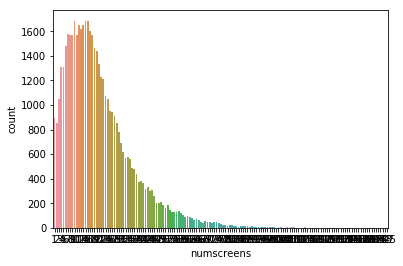

In [ ]:
sns.countplot(ds['numscreens'])

(array([1.4592e+04, 1.6225e+04, 1.0550e+04, 4.7720e+03, 2.6330e+03,
        8.9100e+02, 2.7300e+02, 4.0000e+01, 2.0000e+01, 4.0000e+00]),
 array([ 16. ,  24.5,  33. ,  41.5,  50. ,  58.5,  67. ,  75.5,  84. ,
         92.5, 101. ]),
 <a list of 10 Patch objects>)

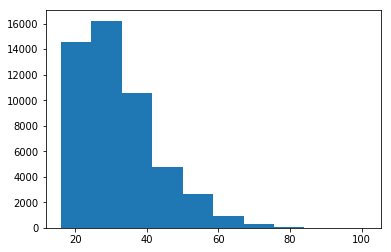

In [ ]:
plt.hist(ds['age'])

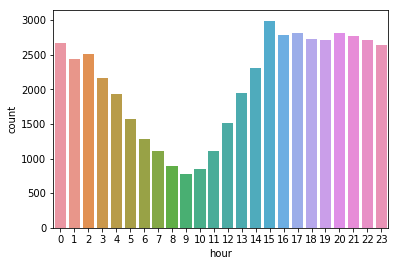

In [ ]:
sns.countplot(ds['hour'])

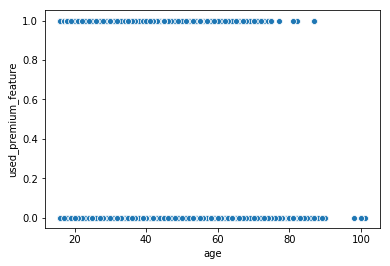

In [ ]:
sns.scatterplot(x = 'age', y = 'used_premium_feature',data = ds)

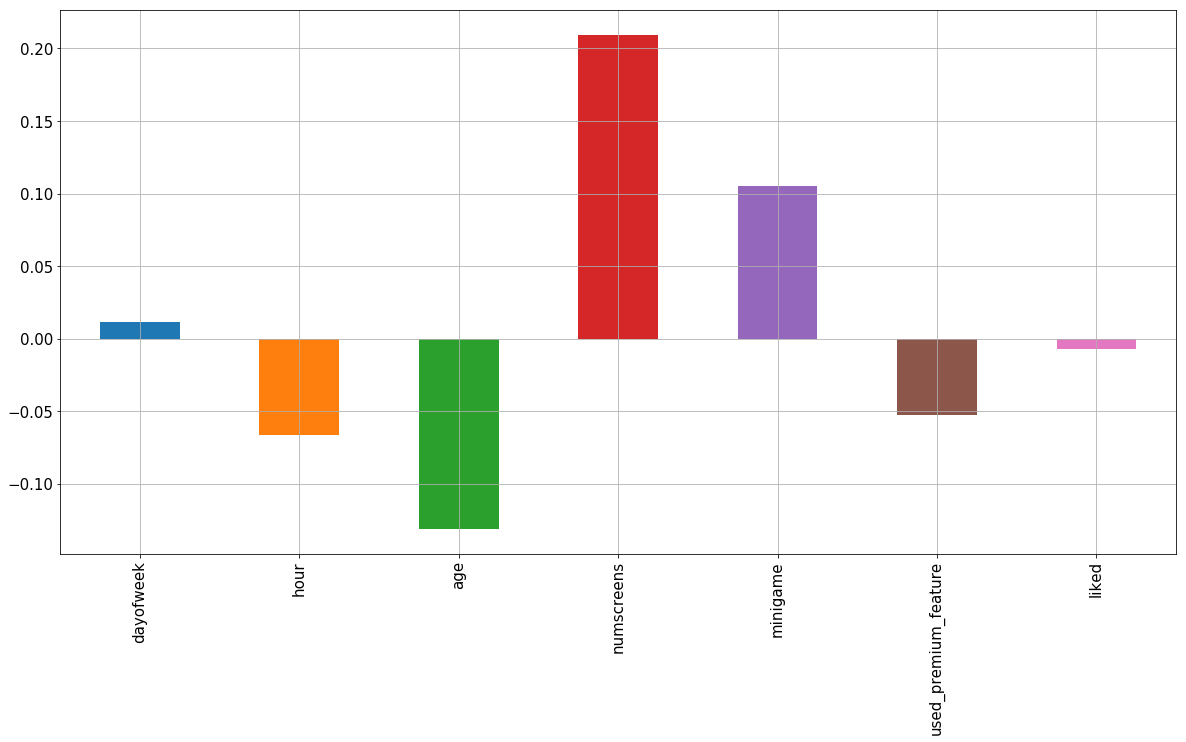

In [ ]:
# figuring out the correlation between our numerical features and the enrollment value
ds.corrwith(dataset.enrolled).plot.bar(figsize= (20, 10), fontsize=15, grid=True)

As it can be seen:
* increase in age has negative effect on enrollment (younger people have higher chance of enrolling in the product)
* increase in numscreens has BIG positive effect on enrollment
* while day of the week or liked have almost no effect on if user enrolled or not
* *one interesting correlation is that when users try the premium features, the chance of them enrolling actually Decreases.*

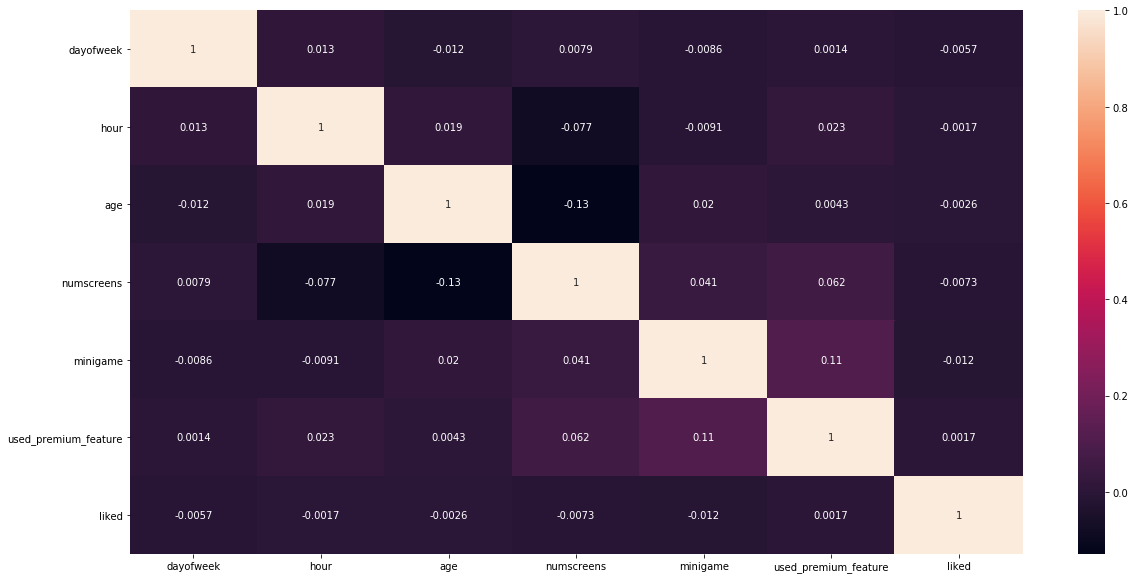

In [ ]:
# Correlation Matrix

plt.figure(figsize=(20, 10))
sns.heatmap(ds.corr(), annot= True)

The correlation heatmap helps us find what features (if any) are dependant on each other This is important because we have this idea that all features are independant of one another and if some of them are actually have linear relationship it will make problems during our training and predictions.

In [ ]:
dataset.dtypes

user                     int64
first_open              object
dayofweek                int64
hour                     int64
age                      int64
screen_list             object
numscreens               int64
minigame                 int64
used_premium_feature     int64
enrolled                 int64
enrolled_date           object
liked                    int64
dtype: object

In [ ]:
# change data type of first_open from string to date type
dataset['first_open'] = [parser.parse(row_data) for row_data in dataset['first_open']]

In [ ]:
dataset['enrolled_date'] = [parser.parse(row_data) if isinstance(row_data, str) else row_data for row_data in dataset['enrolled_date']]

Now that both our first_open and enrolled_date are numerical features we want to find the difference between them
and set a limit for the max time distance between the two

In [ ]:
# astype('timedelta64[h]') : this will make the difference into hours
dataset["difference"] = (dataset.enrolled_date - dataset.first_open).astype('timedelta64[m]')

In [ ]:
print(dataset["difference"].dropna().mean())
print(dataset["difference"].dropna().median())

11461.200167342473
7.0


In [ ]:
# anyone who enrolled more than 6 hours after enrolling, wolud be considered not enrolled 
dataset.loc[dataset.difference > 360, 'enrolled'] = 0

In [ ]:
# we are not gonna use this dates anymore so we drop them
dataset = dataset.drop(columns = ['difference', 'enrolled_date', 'first_open'])

In [ ]:
dataset = dataset.drop(columns = ['user'])

In [ ]:
dataset.head()

,dayofweek,hour,age,screen_list,numscreens,minigame,used_premium_feature,enrolled,liked
0,3,2,23,"idscreen,joinscreen,Cycle,product_review,ScanP...",15,0,0,0,0
1,6,1,24,"joinscreen,product_review,product_review2,Scan...",13,0,0,0,0
2,1,19,23,"Splash,Cycle,Loan",3,0,1,0,1
3,4,16,28,"product_review,Home,product_review,Loan3,Finan...",40,0,0,1,0
4,1,18,31,"idscreen,joinscreen,Cycle,Credit3Container,Sca...",32,0,0,1,1


We have this screen_list column which is text.
the way that we process it here is that we import list of the most prominent screen list activities and assign each of them a column so that in this way we can interpret this as a numerical value.

In [ ]:
top_screens = pd.read_csv("../input/top-screens/top_screens.csv")

In [ ]:
top_screens.head(10)

,Unnamed: 0,top_screens
0,0,Loan2
1,1,location
2,2,Institutions
3,3,Credit3Container
4,4,VerifyPhone
5,5,BankVerification
6,6,VerifyDateOfBirth
7,7,ProfilePage
8,8,VerifyCountry
9,9,Cycle


In [ ]:
dataset['screen_list'] = dataset.screen_list.astype(str) + ', '

In [ ]:
top_screens = top_screens.values  # turn it into a nympy array from a dataframe
ls = top_screens[:,1]
for sc in ls:
    dataset[sc] = dataset.screen_list.str.contains(sc).astype(int)
    dataset["screen_list"] = dataset.screen_list.str.replace(sc+',', "")

Here we turn the top_screen dataframe into a list of string values<br>
then we add each of them to the main dataset:<br>
    *-we search each row of 'screen_list' and if it contains the string same as the one of top_screens values<br>
    -we put 1 for the column of that value otherwise we put zero<br>
    -then we ommit that text from scree_list of that row.<br>*

In [ ]:
dataset.head(3)

,dayofweek,hour,age,screen_list,numscreens,minigame,used_premium_feature,enrolled,liked,Loan2,location,Institutions,Credit3Container,VerifyPhone,BankVerification,VerifyDateOfBirth,ProfilePage,VerifyCountry,Cycle,idscreen,Credit3Dashboard,Loan3,CC1Category,Splash,Loan,CC1,RewardsContainer,Credit3,Credit1,EditProfile,Credit2,Finances,CC3,Saving9,Saving1,Alerts,Saving8,Saving10,Leaderboard,Saving4,VerifyMobile,VerifyHousing,RewardDetail,VerifyHousingAmount,ProfileMaritalStatus,ProfileChildren,ProfileEducation,Saving7,ProfileEducationMajor,Rewards,AccountView,VerifyAnnualIncome,VerifyIncomeType,Saving2,Saving6,Saving2Amount,Saving5,ProfileJobTitle,Login,ProfileEmploymentLength,WebView,SecurityModal,Loan4,ResendToken,TransactionList,NetworkFailure,ListPicker
0,3,2,23,"joinscreen,product_review,ScanPreview,VerifyTo...",15,0,0,0,0,1,0,0,0,1,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,6,1,24,"joinscreen,product_review,product_review2,Scan...",13,0,0,0,0,1,1,1,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,19,23,,3,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


for all the other screen_text activities we make another column and put added up number of all of them there

In [ ]:
dataset['other'] = dataset.screen_list.str.count(",")

In [ ]:
dataset.head(3)

,dayofweek,hour,age,screen_list,numscreens,minigame,used_premium_feature,enrolled,liked,Loan2,location,Institutions,Credit3Container,VerifyPhone,BankVerification,VerifyDateOfBirth,ProfilePage,VerifyCountry,Cycle,idscreen,Credit3Dashboard,Loan3,CC1Category,Splash,Loan,CC1,RewardsContainer,Credit3,Credit1,EditProfile,Credit2,Finances,CC3,Saving9,Saving1,Alerts,Saving8,Saving10,Leaderboard,Saving4,VerifyMobile,VerifyHousing,RewardDetail,VerifyHousingAmount,ProfileMaritalStatus,ProfileChildren,ProfileEducation,Saving7,ProfileEducationMajor,Rewards,AccountView,VerifyAnnualIncome,VerifyIncomeType,Saving2,Saving6,Saving2Amount,Saving5,ProfileJobTitle,Login,ProfileEmploymentLength,WebView,SecurityModal,Loan4,ResendToken,TransactionList,NetworkFailure,ListPicker,other
0,3,2,23,"joinscreen,product_review,ScanPreview,VerifyTo...",15,0,0,0,0,1,0,0,0,1,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,7
1,6,1,24,"joinscreen,product_review,product_review2,Scan...",13,0,0,0,0,1,1,1,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5
2,1,19,23,,3,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# now we can drop the screen_list column
dataset = dataset.drop(columns = ['screen_list'])

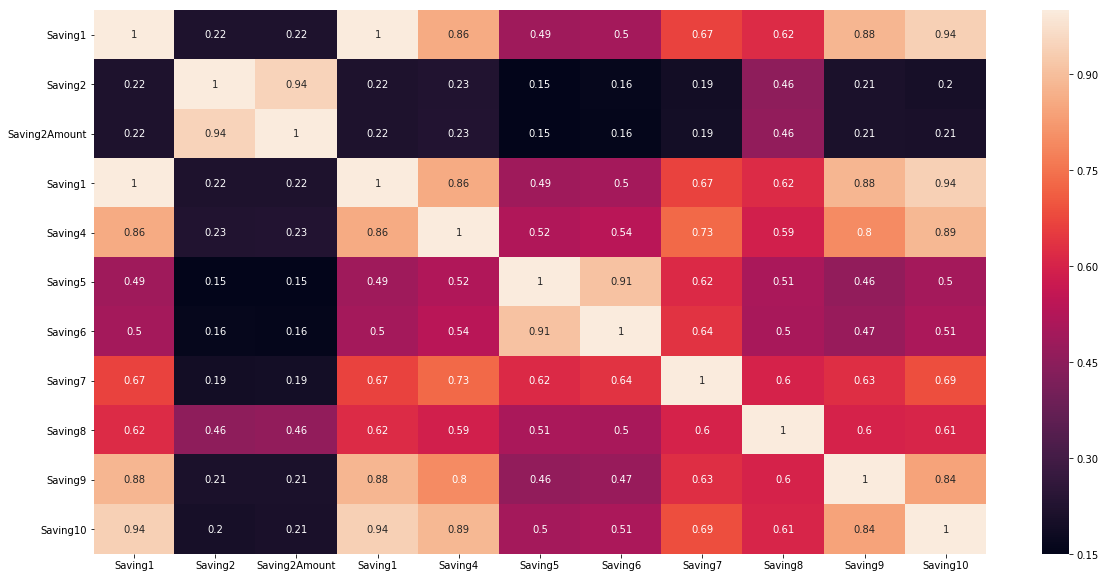

In [ ]:
plt.figure(figsize=(20, 10))
ds_2 = dataset[["Saving1", "Saving2", "Saving2Amount", "Saving1","Saving4","Saving5","Saving6", 
                  "Saving7","Saving8","Saving9","Saving10"]]
sns.heatmap(ds_2.corr(), annot= True)

In [ ]:
# these columns are all highly corelated so we can add them all up into one column
savings_screen = ["Saving1", "Saving2", "Saving2Amount", "Saving1","Saving4","Saving5","Saving6", 
                  "Saving7","Saving8","Saving9","Saving10"]

In [ ]:
dataset.head()

,dayofweek,hour,age,numscreens,minigame,used_premium_feature,enrolled,liked,Loan2,location,Institutions,Credit3Container,VerifyPhone,BankVerification,VerifyDateOfBirth,ProfilePage,VerifyCountry,Cycle,idscreen,Credit3Dashboard,Loan3,CC1Category,Splash,Loan,CC1,RewardsContainer,Credit3,Credit1,EditProfile,Credit2,Finances,CC3,Saving9,Saving1,Alerts,Saving8,Saving10,Leaderboard,Saving4,VerifyMobile,VerifyHousing,RewardDetail,VerifyHousingAmount,ProfileMaritalStatus,ProfileChildren,ProfileEducation,Saving7,ProfileEducationMajor,Rewards,AccountView,VerifyAnnualIncome,VerifyIncomeType,Saving2,Saving6,Saving2Amount,Saving5,ProfileJobTitle,Login,ProfileEmploymentLength,WebView,SecurityModal,Loan4,ResendToken,TransactionList,NetworkFailure,ListPicker,other
0,3,2,23,15,0,0,0,0,1,0,0,0,1,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,7
1,6,1,24,13,0,0,0,0,1,1,1,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5
2,1,19,23,3,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,16,28,40,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,1,0,1,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6
4,1,18,31,32,0,0,1,1,1,0,1,1,1,1,0,0,1,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10


In [ ]:
# add up the values from all columns from savings_screen and then put them in SavingsCount  
dataset['SavingsCount'] = dataset[savings_screen].sum(axis=1)
# next drop all columns of list savings_screen
dataset = dataset.drop(columns=savings_screen)

In [ ]:
cm_screens = ["Credit1", "Credit2", "Credit3", "Credit3Container","Credit3Dashboard"]

dataset['CMCount'] = dataset[cm_screens].sum(axis=1)
dataset = dataset.drop(columns=cm_screens)

In [ ]:
cc_screens = ["CC1", "CC1Category", "CC3"]

dataset['CCCount'] = dataset[cc_screens].sum(axis=1)
dataset = dataset.drop(columns=cc_screens)

In [ ]:
loan_screens = ["Loan", "Loan2", "Loan3", "Loan4"]

dataset['LoanCount'] = dataset[loan_screens].sum(axis=1)
dataset = dataset.drop(columns=loan_screens)

In [ ]:
dataset.head()

,dayofweek,hour,age,numscreens,minigame,used_premium_feature,enrolled,liked,location,Institutions,VerifyPhone,BankVerification,VerifyDateOfBirth,ProfilePage,VerifyCountry,Cycle,idscreen,Splash,RewardsContainer,EditProfile,Finances,Alerts,Leaderboard,VerifyMobile,VerifyHousing,RewardDetail,VerifyHousingAmount,ProfileMaritalStatus,ProfileChildren,ProfileEducation,ProfileEducationMajor,Rewards,AccountView,VerifyAnnualIncome,VerifyIncomeType,ProfileJobTitle,Login,ProfileEmploymentLength,WebView,SecurityModal,ResendToken,TransactionList,NetworkFailure,ListPicker,other,SavingsCount,CMCount,CCCount,LoanCount
0,3,2,23,15,0,0,0,0,0,0,1,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,7,0,0,0,1
1,6,1,24,13,0,0,0,0,1,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,1
2,1,19,23,3,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,4,16,28,40,0,0,1,0,1,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,6,0,3,0,1
4,1,18,31,32,0,0,1,1,0,1,1,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,0,2,0,1


In [ ]:
Y = dataset['enrolled']
X = dataset.drop(columns="enrolled")

In [ ]:
SC = StandardScaler()
X = SC.fit_transform(X)

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [ ]:
print(len(X_train))
print(len(X_test))

40000
10000


In [ ]:
# here we have a binary classification (0/1) so we can use a logistic regression classifer to predict the results
# we apply L1 penalty for regularization of our model to prevent overfitting
classifier = LogisticRegression(random_state=0, penalty='l1')
classifier.fit(X_train, Y_train)

y_pred = classifier.predict(X_test)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [ ]:
cm = confusion_matrix(Y_test, y_pred)
print(cm)

[[4552 1032]
 [ 972 3444]]


In [ ]:
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.82      0.82      5584
           1       0.77      0.78      0.77      4416

   micro avg       0.80      0.80      0.80     10000
   macro avg       0.80      0.80      0.80     10000
weighted avg       0.80      0.80      0.80     10000



In [ ]:
param_grid = {'C':[0.1, 1, 10, 100], 'penalty': ['l1', 'l2']}


grid = GridSearchCV(LogisticRegression(), param_grid, verbose= 4, cv=3, refit=True)
grid.fit(X_train, Y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] C=0.1, penalty=l1 ...............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV] ...... C=0.1, penalty=l1, score=0.7981850907454627, total=   0.4s
[CV] C=0.1, penalty=l1 ...............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV] ...... C=0.1, penalty=l1, score=0.7930853457327134, total=   0.3s
[CV] C=0.1, penalty=l1 ...............................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV] ...... C=0.1, penalty=l1, score=0.7884788478847885, total=   0.3s
[CV] C=0.1, penalty=l2 ...............................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.0s remaining:    0.0s
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV] ...... C=0.1, penalty=l2, score=0.7984850757462126, total=   0.3s
[CV] C=0.1, penalty=l2 ...............................................


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV] ...... C=0.1, penalty=l2, score=0.7927103644817759, total=   0.3s
[CV] C=0.1, penalty=l2 ...............................................


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV] ...... C=0.1, penalty=l2, score=0.7889288928892889, total=   0.3s
[CV] C=1, penalty=l1 .................................................


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV] ........ C=1, penalty=l1, score=0.7981100944952753, total=   0.5s
[CV] C=1, penalty=l1 .................................................


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV] ........ C=1, penalty=l1, score=0.7930103494825259, total=   0.4s
[CV] C=1, penalty=l1 .................................................


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV] ........ C=1, penalty=l1, score=0.7892289228922892, total=   0.3s
[CV] C=1, penalty=l2 .................................................


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV] ........ C=1, penalty=l2, score=0.7982600869956502, total=   0.3s
[CV] C=1, penalty=l2 .................................................


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV] ........ C=1, penalty=l2, score=0.7930103494825259, total=   0.3s
[CV] C=1, penalty=l2 .................................................


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV] ........ C=1, penalty=l2, score=0.7888538853885388, total=   0.3s
[CV] C=10, penalty=l1 ................................................


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV] ....... C=10, penalty=l1, score=0.7982600869956502, total=   0.4s
[CV] C=10, penalty=l1 ................................................


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV] ....... C=10, penalty=l1, score=0.7931603419829009, total=   0.4s
[CV] C=10, penalty=l1 ................................................


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV] ....... C=10, penalty=l1, score=0.7888538853885388, total=   0.4s
[CV] C=10, penalty=l2 ................................................


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV] ....... C=10, penalty=l2, score=0.7983350832458377, total=   0.3s
[CV] C=10, penalty=l2 ................................................


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV] ....... C=10, penalty=l2, score=0.7929353532323384, total=   0.3s
[CV] C=10, penalty=l2 ................................................


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV] ....... C=10, penalty=l2, score=0.7887788778877888, total=   0.3s
[CV] C=100, penalty=l1 ...............................................


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV] ...... C=100, penalty=l1, score=0.7983350832458377, total=   0.4s
[CV] C=100, penalty=l1 ...............................................


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV] ...... C=100, penalty=l1, score=0.7930103494825259, total=   0.4s
[CV] C=100, penalty=l1 ...............................................


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV] ...... C=100, penalty=l1, score=0.7888538853885388, total=   0.4s
[CV] C=100, penalty=l2 ...............................................


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV] ...... C=100, penalty=l2, score=0.7983350832458377, total=   0.3s
[CV] C=100, penalty=l2 ...............................................


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV] ...... C=100, penalty=l2, score=0.7929353532323384, total=   0.3s
[CV] C=100, penalty=l2 ...............................................


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV] ...... C=100, penalty=l2, score=0.7887788778877888, total=   0.3s


[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    8.2s finished
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.1, 1, 10, 100], 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=4)

In [ ]:
grid.best_params_

{'C': 1, 'penalty': 'l1'}

In [ ]:
y_predict = grid.predict(X_test)
print(classification_report(Y_test, y_predict))

              precision    recall  f1-score   support

           0       0.82      0.82      0.82      5584
           1       0.77      0.78      0.77      4416

   micro avg       0.80      0.80      0.80     10000
   macro avg       0.80      0.80      0.80     10000
weighted avg       0.80      0.80      0.80     10000



In [ ]:
cm = confusion_matrix(Y_test, y_predict)
print(cm)

[[4552 1032]
 [ 973 3443]]
